In [ ]:
!pip install ucimlrepo
!pip install libsvm-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.32.1 requires numpy<2.0.0,>=1.17, but you have numpy 2.0.1 which is incompatible.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.1 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.0.1 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.1 which is incompatible.
ibis-framework 8.0.0 requires numpy<2,>=1, but you have numpy 2.0.1 which is incompatible.
numba 0.58.1 requires numpy<1.27,>=1.22, but you have numpy 2.0.1 which is incompatible.
rmm-cu12 24.4.0 requires numpy<2.0a0,>=1.

Streaming output truncated to the last 5000 lines.
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 65.123%
Cross Validat

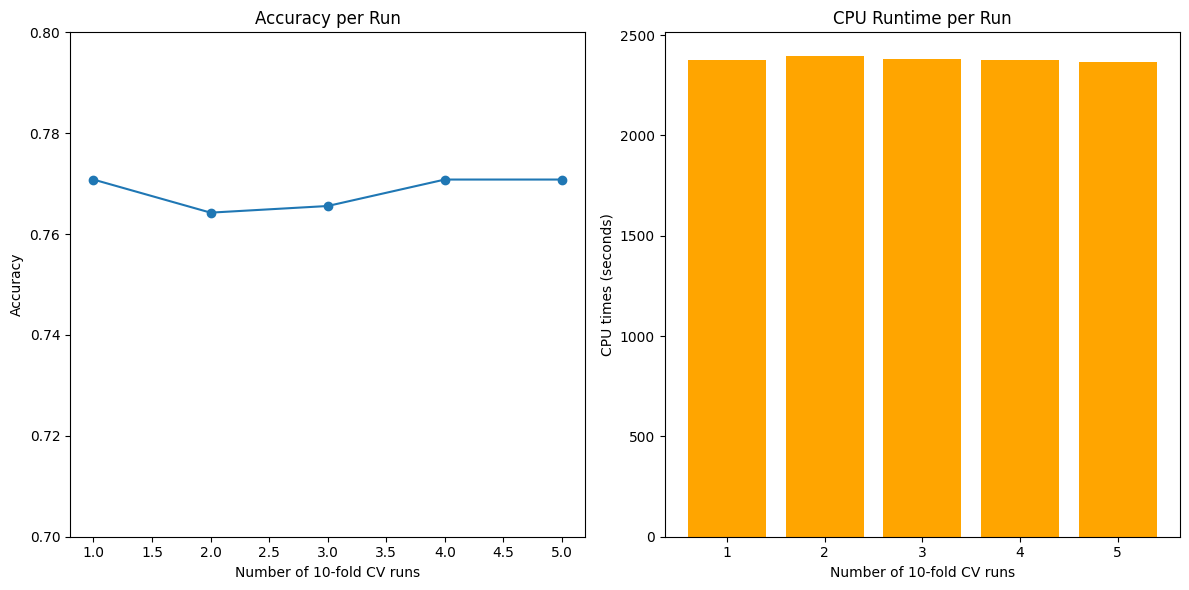

In [4]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from libsvm.svmutil import *

class FOASVM:
    def __init__(self, population_size=8, max_iterations=250, ax=20, bx=10, ay=20, by=10):
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.ax = ax
        self.bx = bx
        self.ay = ay
        self.by = by

    def initialize_population(self):
        self.X_axis = np.random.uniform(-1, 1, 2)
        self.Y_axis = np.random.uniform(-1, 1, 2)

    def smell_concentration(self, C, gamma, X, y):
        prob = svm_problem(y.tolist(), X.tolist())
        param = svm_parameter(f'-s 0 -t 2 -c {C} -g {gamma} -v 5')
        score = svm_train(prob, param)
        return score / 100  # Convert percentage to fraction

    def search(self, X, y):
        best_score = -np.inf
        best_C = 0
        best_gamma = 0

        for _ in range(self.max_iterations):
            X_pos = self.X_axis + self.ax * np.random.rand(self.population_size, 2) - self.bx
            Y_pos = self.Y_axis + self.ay * np.random.rand(self.population_size, 2) - self.by

            D = np.sqrt(X_pos**2 + Y_pos**2)
            S = 1 / D

            for i in range(self.population_size):
                C = 2**np.clip(S[i, 0] * 20 - 5, -5, 15)
                gamma = 2**np.clip(S[i, 1] * 15 - 15, -15, 3)

                score = self.smell_concentration(C, gamma, X, y)

                if score > best_score:
                    best_score = score
                    best_C = C
                    best_gamma = gamma
                    self.X_axis = X_pos[i]
                    self.Y_axis = Y_pos[i]

        return best_C, best_gamma, best_score

    def fit(self, X, y):
        self.X = X
        self.y = y

        scaler = MinMaxScaler(feature_range=(-1, 1))
        self.X = scaler.fit_transform(self.X)

        outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        all_outer_scores = []
        all_auc_scores = []
        all_sensitivity_scores = []
        all_specificity_scores = []
        all_run_times = []

        for _ in range(5):  # Repeat the 10-fold CV procedure 5 times
            outer_scores = []
            auc_scores = []
            sensitivity_scores = []
            specificity_scores = []
            start_time = time.time()

            for train_index, test_index in outer_cv.split(self.X, self.y):
                X_train, X_test = self.X[train_index], self.X[test_index]
                y_train, y_test = self.y[train_index], self.y[test_index]

                self.initialize_population()
                best_C, best_gamma, _ = self.search(X_train, y_train)

                prob = svm_problem(y_train.tolist(), X_train.tolist())
                param = svm_parameter(f'-s 0 -t 2 -c {best_C} -g {best_gamma} -b 1')
                model = svm_train(prob, param)

                p_label, p_acc, p_val = svm_predict(y_test.tolist(), X_test.tolist(), model, '-b 1')

                score = p_acc[0] / 100  # Accuracy
                outer_scores.append(score)

                # Calculate AUC from probability estimates
                positive_class_index = 0 # Index corresponding to class 0
                positive_probabilities = [val[positive_class_index] for val in p_val]  # Extract probability of positive class
                auc = roc_auc_score(y_test, positive_probabilities)
                auc_scores.append(auc)

                # Calculate sensitivity and specificity
                tn, fp, fn, tp = confusion_matrix(y_test, p_label).ravel()
                sensitivity = tp / (tp + fn)
                specificity = tn / (tn + fp)

                sensitivity_scores.append(sensitivity)
                specificity_scores.append(specificity)

            end_time = time.time()
            all_outer_scores.extend(outer_scores)
            all_auc_scores.extend(auc_scores)
            all_sensitivity_scores.extend(sensitivity_scores)
            all_specificity_scores.extend(specificity_scores)
            all_run_times.append(end_time - start_time)

        mean_accuracy = np.mean(all_outer_scores)
        std_accuracy = np.std(all_outer_scores)
        mean_auc = np.mean(all_auc_scores)
        std_auc = np.std(all_auc_scores)
        mean_sensitivity = np.mean(all_sensitivity_scores)
        std_sensitivity = np.std(all_sensitivity_scores)
        mean_specificity = np.mean(all_specificity_scores)
        std_specificity = np.std(all_specificity_scores)

        return (mean_accuracy, std_accuracy, mean_auc, std_auc,
                mean_sensitivity, std_sensitivity, mean_specificity, std_specificity,
                all_run_times, all_outer_scores)

# fetch dataset
diabetes = pd.read_csv('Pima Indians diabetes (Pima).csv')

# data (as pandas dataframes)
X = diabetes.iloc[:, :-1].values
y = diabetes.iloc[:, -1].values

foa_svm = FOASVM()
(mean_accuracy, std_accuracy, mean_auc, std_auc,
 mean_sensitivity, std_sensitivity, mean_specificity, std_specificity,
 all_run_times, all_outer_scores) = foa_svm.fit(X, y)

print(f'Mean accuracy: {mean_accuracy:.4f}')
print(f'Standard deviation of accuracy: {std_accuracy:.4f}')
print(f'Mean AUC: {mean_auc:.4f}')
print(f'Standard deviation of AUC: {std_auc:.4f}')
print(f'Mean sensitivity: {mean_sensitivity:.4f}')
print(f'Standard deviation of sensitivity: {std_sensitivity:.4f}')
print(f'Mean specificity: {mean_specificity:.4f}')
print(f'Standard deviation of specificity: {std_specificity:.4f}')

# Plotting accuracy and CPU runtime per run
plt.figure(figsize=(12, 6))

# Plot accuracy per run
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), [np.mean(all_outer_scores[i*10:(i+1)*10]) for i in range(5)], marker='o')
plt.title('Accuracy per Run')
plt.xlabel('Number of 10-fold CV runs')
plt.ylabel('Accuracy')
plt.ylim(0.70, 0.80)

# Plot CPU runtime per run as a bar chart
plt.subplot(1, 2, 2)
plt.bar(range(1, 6), all_run_times, color='orange')
plt.title('CPU Runtime per Run')
plt.xlabel('Number of 10-fold CV runs')
plt.ylabel('CPU times (seconds)')

plt.tight_layout()
plt.show()
